# Question
The following figures show the Di Wang Tower in Shenzhen. The structure of Di Wang Tower is made up of steel and reinforced concrete (calculated as reinforced concrete), C terrain type, the design wind pressure $w_0 = 0.75 \text{ kN/m}^2$, period $T_1=6.38\text{ s}$, The first mode shape is listed in following table. To determine shape factor, the cross section could be considered as rectangle.

![The Elvation of the DiWang Tower](./images/Diwang01.png)
![The Plan View of the DiWang Tower](./images/Diwang02.png)

<b>Table 1: The first mode shape and mass of the DiWang Tower</b>

| $\dfrac{h}{H}$ | 0     | 0.1   | 0.2   | 0.3   | 0.4    | 0.5   | 0.6   | 0.7    | 0.8   | 0.9   | 1.0   |
| -------------- | ----- | ----- | ----- | ----- | ------ | ----- | ----- | ------ | ----- | ----- | ----- |
| Mode shape     | 0.0000| 0.0137| 0.0558| 0.1277| 0.2424| 0.3503| 0.4629| 0.5903| 0.7309| 0.8700| 1.0000| 
| Mass / ton     | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 1500  | 

Only consider the first mode, calculate **the extreme of top displacements** induced by the along-wind static and dynamic wind load in the given wind direction using the following methods:
1. Method recommended by the Chinese code for wind-resistant design of buildings (GB 50009-2012).
2. According to the quasi-steady assumption, convert the fluctuating wind velocity time histories in `windData` (**with a duration of 10 minutes and a sampling frequency of 10 Hz**) to wind load time histories $F_i(t)=[1/2\rho \bar{u_i}^2+\rho \bar{u_i} u'_i(t)] \cdot \mu_{s,i} \cdot A_i$, and then using stocastic vibration methods in time domain (such as the newmark-beta algorithm) and in frequency domain (such as the response spectrum analysis). Peak factor $g = 2.5$ should be used for the extreme value calculation, and the programming using frequency domain method is optional.

# Answer


In [1]:
import scipy.io as sio

# load data
simDataPath = './windData/windData.mat'
simData = sio.loadmat(simDataPath, squeeze_me=True, struct_as_record=False)
U = simData['U']
Z = simData['Z']
dt = simData['dt']
t = simData['t']
del simData
print("The dimension of U is:", U.shape)

The dimension of U is: (11, 6000)


## Answer1


The dimension of U is: (11, 6000)


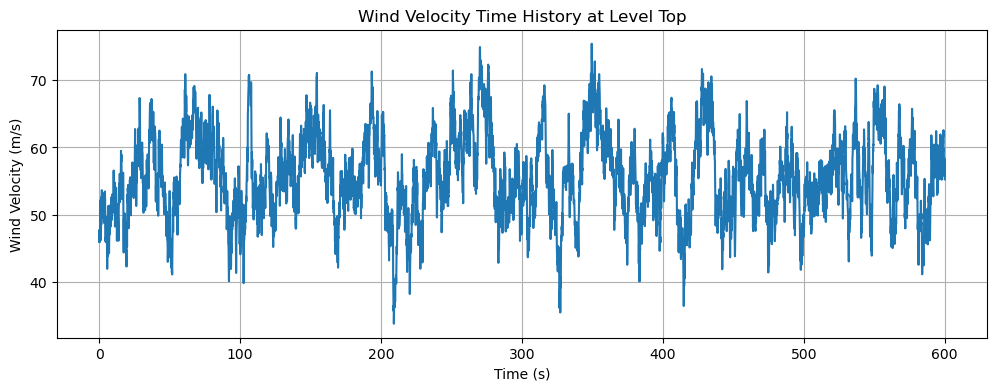


风荷载计算结果表：
----------------------------------------------------------------------
高度比例       实际高度(m)         风压(kN/m²)       风荷载(kN)        
----------------------------------------------------------------------
0.0        0.00            0.00            0.00           
0.1        32.49           0.98            3136.79        
0.2        64.99           1.37            2938.49        
0.3        97.48           1.72            3678.91        
0.4        129.98          2.07            4441.37        
0.5        162.47          2.39            5125.81        
0.6        194.97          2.70            5781.43        
0.7        227.46          3.01            6446.23        
0.8        259.96          3.33            7122.57        
0.9        292.45          3.63            7774.98        
1.0        324.95          3.92            4193.03        
----------------------------------------------------------------------


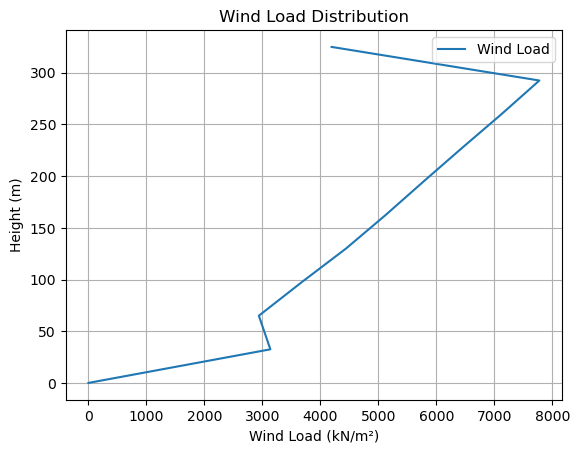

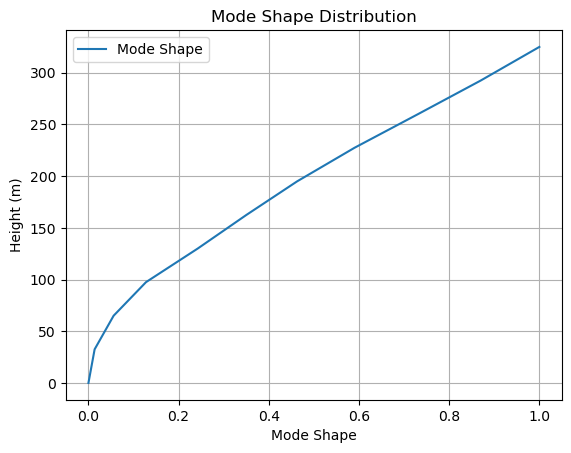

结构的顶部位移为: 4.07 m


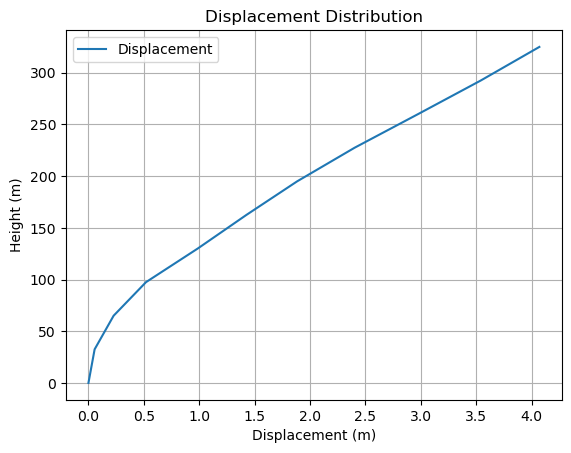

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.fft import fft, ifft, fftfreq
from scipy import signal

# 设置matplotlib中文字体
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
# plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

# 加载数据 - 保留simData以便检查
simDataPath = './windData/windData.mat'
simData = sio.loadmat(simDataPath, squeeze_me=True, struct_as_record=False)
U = simData['U']
Z = simData['Z']
dt = simData['dt']
t = simData['t']
print("\nThe dimension of U is:", U.shape)

# 绘制顶层风速时程
plt.figure(figsize=(12, 4))
plt.plot(t, U[-1])
plt.xlabel('Time (s)')
plt.ylabel('Wind Velocity (m/s)')
plt.title('Wind Velocity Time History at Level Top')
plt.grid(True)
plt.show()

class WindLoadCalculator:
    def __init__(self, U, Z, B=65.88, D=35.5, w_0=0.75, mode_shape=None, h_ratio=None, h_part_ratio=None, terrain_type='C'):
        """初始化风荷载计算器"""
        self.U = U
        self.U_mean = np.mean(U, axis=1) # 计算平均风速
        self.U_fluctuation = U - self.U_mean[:, np.newaxis]
        self.w_0 = w_0

        self.Z = Z
        self.H = Z[-1]
        self.B = B
        self.D = D
        
        self.mode_shape = np.array(mode_shape) if mode_shape is not None else np.array([])
        self.h_ratio = np.array(h_ratio) if h_ratio is not None else np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
        self.h_part_ratio = np.array(h_part_ratio) if h_ratio is not None else np.array([0, 0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05])
        
        self.terrain_type = terrain_type
        self.rho = 1.225  # 空气密度 (kg/m³)
        self.A_i = self.B * self.h_part_ratio * self.H  # 各层迎风面积

    def get_shape_factor(self):
        """计算风荷载体型系数"""
        return 1.4
    
    def get_height_variation(self):
        """计算高度变化系数"""
        alpha = {
            'A': 1.284,
            'B': 1.000,
            'C': 0.544,
            'D': 0.262
        }
        beta = {
            'A': 0.24,
            'B': 0.30,
            'C': 0.44,
            'D': 0.60
        }
        return alpha[self.terrain_type] * (self.Z / 10) ** beta[self.terrain_type]

    def get_vibration_factor(self, f_1 = 1/6.38):
        """计算振动因子"""
        
        # 峰值因子
        g = 2.5
        # 10m高度名义湍流强度
        I_10 = {
            'A': 0.12,
            'B': 0.14,
            'C': 0.23,
            'D': 0.39
        }

        # 脉动风荷载的背景分量因子
        kesai_1 = 0.05 # 结构阻尼比
        k_w = {
            'A': 1.28,
            'B': 1,
            'C': 0.54,
            'D': 0.26
        } # 地面粗糙度修正系数

        x_1 = max(30*f_1/math.sqrt(k_w[self.terrain_type]*self.w_0),5)
        R = math.sqrt(np.pi / (6 * kesai_1)*x_1**2/(1 + x_1**2)**(4/3))

        # 脉动风荷载的共振分量因子
        alpha_1 = {
            'A': 0.155,
            'B': 0.187,
            'C': 0.261,
            'D': 0.346
        }
        k = {
            'A': 0.944,
            'B': 0.670,
            'C': 0.295,
            'D': 0.112
        }
        rho_x = 10 * math.sqrt(self.H + 60 * np.exp(-self.H / 60) - 60) / self.H
        rho_z = 10 * math.sqrt(self.B + 50 * np.exp(-self.B / 50) - 50) / self.B
        mu_z = self.get_height_variation()
        B_z = k[self.terrain_type] * H ** alpha_1[self.terrain_type] *rho_x * rho_z * self.mode_shape / mu_z

        return 1 + 2 * g * I_10[self.terrain_type] * B_z * math.sqrt(1 + R ** 2)

    def calculate_static_wind_load_GB(self, f_1=1/6.38):
        """计算静态风荷载"""

        # GB 50009-2012规范中风荷载标准值的计算方法
        # 公式：w_k = Beta_z * mu_s * mu_z * w_0
        beta_z = self.get_vibration_factor(f_1=f_1)
        mu_s = self.get_shape_factor()
        mu_z = self.get_height_variation()
        # 计算风压
        w_k = beta_z * mu_s * mu_z * self.w_0
        
        # 计算各层风荷载
        # F_z = w_k * self.B * self.h_part_ratio * self.H
        
        F_z = w_k * self.A_i
        # 打印表格形式的结果
        print("\n风荷载计算结果表：")
        print("-" * 70)
        print("{:<10} {:<15} {:<15} {:<15}".format("高度比例", "实际高度(m)", "风压(kN/m²)", "风荷载(kN)"))
        print("-" * 70)
        for i in range(len(F_z)):
            print("{:<10.1f} {:<15.2f} {:<15.2f} {:<15.2f}".format(
                self.h_ratio[i], 
                self.h_ratio[i] * self.H, 
                w_k[i], 
                F_z[i]
            ))
        print("-" * 70)

        plt.figure()
        plt.plot(F_z, self.Z, label='Wind Load')
        plt.ylabel('Height (m)')
        plt.xlabel('Wind Load (kN/m²)')
        plt.title('Wind Load Distribution')
        plt.grid(True)
        plt.legend()
        plt.show()

        return F_z

    def calculate_static_wind_load_Time(self):
        """计算风荷载时程"""

        mu_s = self.get_shape_factor()
        
        # 计算各层风荷载
        F_z_t = (0.5 * self.rho * self.U_mean[:, np.newaxis] ** 2 + self.rho * self.U_mean[:, np.newaxis]
                  * self.U_fluctuation) * mu_s * self.A_i[:, np.newaxis]

        # 建筑顶部风荷载时程
        plt.figure(figsize=(12, 4))
        plt.plot(t, F_z_t[-1], label='Wind Load Time History')
        plt.xlabel('Time (s)')
        plt.ylabel('Wind Load (N)')
        plt.title('Wind Load Time History at Level Top')
        plt.grid(True)
        plt.legend()
        plt.show()

        return F_z_t
    
    def calculate_static_wind_load_Frequency(self):
        """计算风荷载功率谱密度"""

        mu_s = self.get_shape_factor()
        
        # 计算各层风荷载
        F_z_t = (0.5 * self.rho * self.U_mean[:, np.newaxis] ** 2 + self.rho * self.U_mean[:, np.newaxis]
                  * self.U_fluctuation) * mu_s * self.A_i[:, np.newaxis]

        # 使用矩阵乘法计算模态力 - 一行代码替代循环
        F_gen = np.dot(self.mode_shape, F_z_t)

        # 建筑顶部风荷载时程
        f, psd_force = signal.welch(F_gen, fs=1/dt, nperseg=1024, noverlap=512)
        
        plt.figure()
        plt.loglog(f, psd_force, label='Wind Load PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Spectral Density')
        plt.title('Wind Load Power Spectral Density')
        plt.grid(True)
        plt.legend()
        plt.show()

        return F_z_t
    
class StructuralAnalysis:
    def __init__(self, mass, mode_shape, T1, Z, B, h_part_ratio, damping_ratio=0.05):
        """初始化结构分析器
        Args:
            mass: 质量分布(t)
            mode_shape: 第一阶振型
            T1: 第一阶自振周期(s)
            U: 风速时程数据
            B: 迎风面宽度(m)
            H: 建筑物高度(m)
            h_part_ratio: 各层高度比例
            damping_ratio: 阻尼比
        """
        self.mass = mass * 1000  # 转换为kg
        self.mode_shape = mode_shape
        self.T1 = T1
        self.damping_ratio = damping_ratio
        self.Z = Z
        self.B = B
        
        # 计算广义质量和刚度
        self.M_gen = np.sum(self.mass * self.mode_shape**2)
        self.K_gen = (2*np.pi/T1)**2 * self.M_gen
        self.C_gen = 2 * self.damping_ratio * np.sqrt(self.K_gen * self.M_gen)
        self.ndof = len(self.mass)  # 自由度数量

        plt.figure()
        plt.plot(self.mode_shape, self.Z, label='Mode Shape')
        plt.xlabel('Mode Shape')
        plt.ylabel('Height (m)')
        plt.title('Mode Shape Distribution')
        plt.grid(True)
        plt.legend()
        plt.show()
        
    def calculate_displacement_GB(self, F_z):
        """计算位移响应
        Returns:
            y: 位移响应，shape: (time_steps, ndof)，每一列代表一个节点的位移时程
        """
        # 将风荷载单位从kN转换为N
        F_z = F_z * 1000  # 这里添加单位转换

        # 计算模态力
        F_1 = np.sum(self.mode_shape * F_z, axis=0)  # 第一阶模态力

        # 计算固有频率
        omega1 = 2 * np.pi / self.T1
        
        # 计算模态坐标
        eta1 = F_1 / (self.M_gen * omega1 ** 2)
        
        # 计算物理坐标下的位移
        X = eta1 * self.mode_shape

        return X
    
    @staticmethod
    def newmark_beta(m, c, k, F, dt, beta=0.25, gamma=0.5):
        n = len(F)
        x = np.zeros(n)
        v = np.zeros(n)
        a = np.zeros(n)
        
        # 初始条件
        x[0] = 0
        v[0] = 0
        a[0] = (F[0] - c * v[0] - k * x[0]) / m
        
        # Newmark-β迭代
        for i in range(1, n):
            # 预测步
            x_pred = x[i-1] + dt*v[i-1] + 0.5*dt**2*a[i-1]
            v_pred = v[i-1] + dt*a[i-1]
            
            # 修正步
            a[i] = (F[i] - c*v_pred - k*x_pred) / m
            x[i] = x_pred + beta*dt**2*(a[i] - a[i-1])
            v[i] = v_pred + gamma*dt*(a[i] - a[i-1])
        
        return x, v, a
    
    def calculate_displacement_Time(self, F_t):
        """计算位移响应
        Returns:
            x_time: 位移时程
            v_time: 速度时程
            a_time: 加速度时程
        """
        # 使用矩阵乘法计算模态力 - 一行代码替代循环
        F_gen = np.dot(self.mode_shape, F_t)

        # 使用Newmark-β算法计算位移时程
        x_time, v_time, a_time = self.newmark_beta(self.M_gen, self.C_gen , self.K_gen, F_gen, dt)

        # 计算物理坐标下的位移响应（所有时间步的完整响应）
        x_physical = np.outer(x_time, self.mode_shape)

        return x_physical
    
    # 计算位移响应 - 频域方法
    @staticmethod
    def frequency_domain_analysis(m, c, k, F, dt):
        n = len(F)
        
        # 计算FFT
        F_fft = fft(F)
        freq = fftfreq(n, dt)
        
        # 计算频率响应函数 (仅计算正频率部分)
        pos_freq_idx = np.where(freq > 0)
        omega = 2 * np.pi * freq
        
        # 初始化频率响应函数
        H = np.zeros(len(freq), dtype=complex)
        
        # 计算频响函数 H(ω) = 1/[k - mω² + jcω]
        for idx in pos_freq_idx[0]:
            H[idx] = 1.0 / complex(k - m * omega[idx]**2, c * omega[idx])
        
        # 负频率部分取共轭
        for i in range(1, n//2):
            H[n-i] = np.conj(H[i])
        
        # 计算位移的FFT
        X_fft = F_fft * H
        
        # 计算位移时程
        x = np.real(ifft(X_fft))
        
        # 返回位移和频率
        return x, freq
    
    def calculate_displacement_Frequency(self, F_t):
        """计算位移响应
        Returns:
            x_time: 位移时程
            v_time: 速度时程
            a_time: 加速度时程
        """
        # 使用矩阵乘法计算模态力 - 一行代码替代循环
        F_gen = np.dot(self.mode_shape, F_t)
        
        F_gen_mean = np.mean(F_gen)  # 计算平均风速        
        x_static = F_gen_mean / self.K_gen # 静态位移响应

        # 使用Newmark-β算法计算位移时程
        x_freq, freq = self.frequency_domain_analysis(self.M_gen, self.C_gen, self.K_gen, F_gen, dt)

        # 计算物理坐标下的位移响应（所有时间步的完整响应）
        x_physical = x_static + np.outer(x_freq, self.mode_shape)

        return x_physical

# 结构参数
H = 324.95  # 建筑物高度(m)
B = 65.88   # 迎风面宽度(m)
D = 35.5    # 横向宽度(m)
T1 = 6.38   # 第一阶自振周期(s)
g = 2.5     # 峰值因子
# rho = 1.225  # 空气密度 (kg/m³)

# 高度比和振型
h_ratio = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
h_part_ratio = np.array([0, 0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05])
mode_shape = np.array([0.0000, 0.0137, 0.0558, 0.1277, 0.2424, 0.3503, 0.4629, 0.5903, 0.7309, 0.8700, 1.0000])
mass = np.array([2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 1500])  # 单位: ton

# 1. GB 50009-2012规范计算
windload = WindLoadCalculator(U=U,Z=Z, B=B, D=D, mode_shape=mode_shape, h_ratio=h_ratio, h_part_ratio=h_part_ratio,terrain_type='C')
result = windload.calculate_static_wind_load_GB()

structural_analysis = StructuralAnalysis(mass, mode_shape, T1, Z, B, h_part_ratio=h_part_ratio,damping_ratio=0.05)
y = structural_analysis.calculate_displacement_GB(result)

y_top = y[-1]  # 提取顶点位移时程
print(f"结构的顶部位移为: {y_top:.2f} m")

plt.figure()
plt.plot(y, Z, label='Displacement')
plt.xlabel('Displacement (m)')
plt.ylabel('Height (m)')
plt.title('Displacement Distribution')
plt.grid(True)
plt.legend()
plt.show()


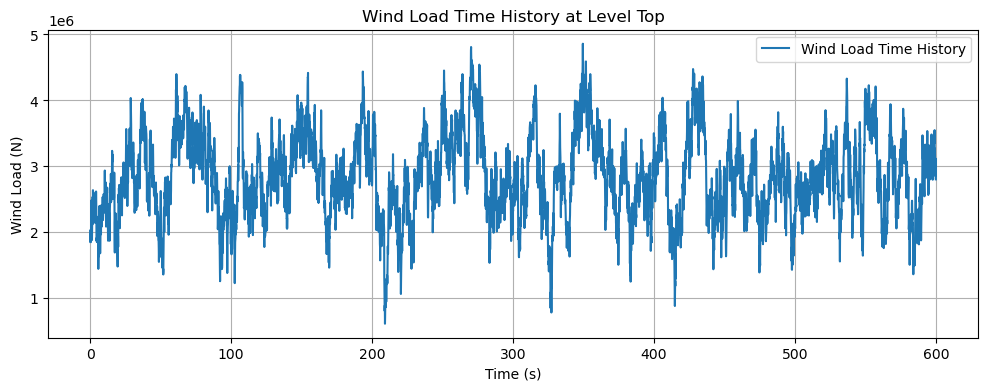

结构顶部位移峰值为: 4.57 m


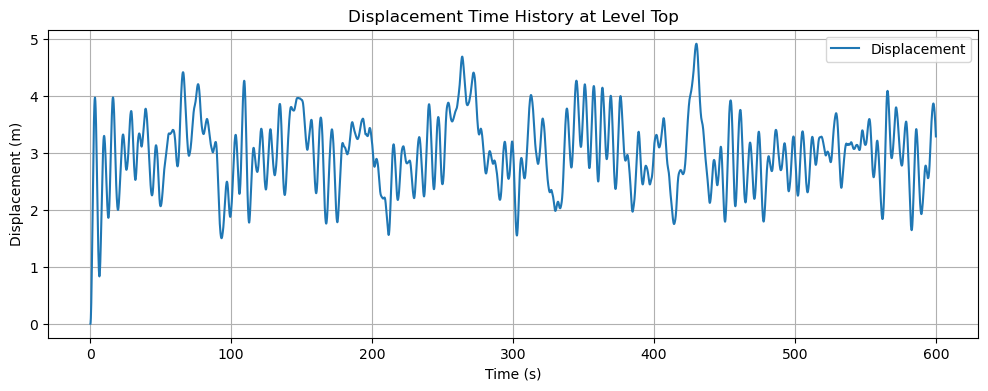

In [3]:
# 2. 时域方法计算
result = windload.calculate_static_wind_load_Time()

y = structural_analysis.calculate_displacement_Time(result)
y_top = y[:,-1]  # 提取顶点位移时程
# 计算位移时程极值
y_top_peak = np.mean(y_top) + g * np.std(y_top)
print(f"结构顶部位移峰值为: {y_top_peak:.2f} m")

plt.figure(figsize=(12, 4))
plt.plot(t, y_top, label='Displacement')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Displacement Time History at Level Top')
plt.grid(True)
plt.legend()
plt.show()


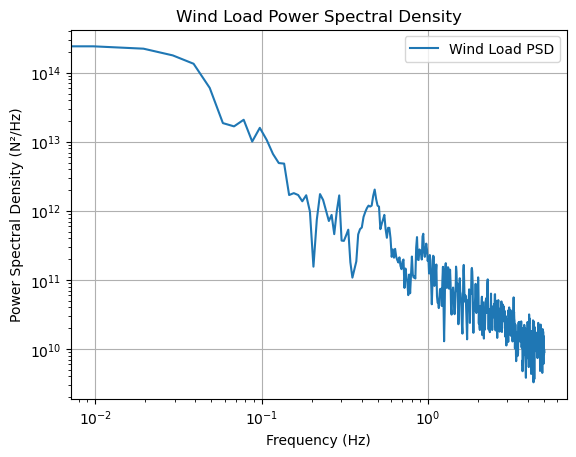

y shape: (6000, 11)
y: [[3.00057373 3.00367788 3.0132169  ... 3.16618107 3.19769835 3.22715376]
 [3.00057373 3.002816   3.00970647 ... 3.12019955 3.14296594 3.16424293]
 [3.00057373 3.00184615 3.00575629 ... 3.06845776 3.081377   3.09345105]
 ...
 [3.00057373 3.00591725 3.02233786 ... 3.28565253 3.33990682 3.39061176]
 [3.00057373 3.0051793  3.01933216 ... 3.24628222 3.29304381 3.33674624]
 [3.00057373 3.00443663 3.01630729 ... 3.2066607  3.24588179 3.28253702]]

结构顶部位移峰值为: 4.55 m


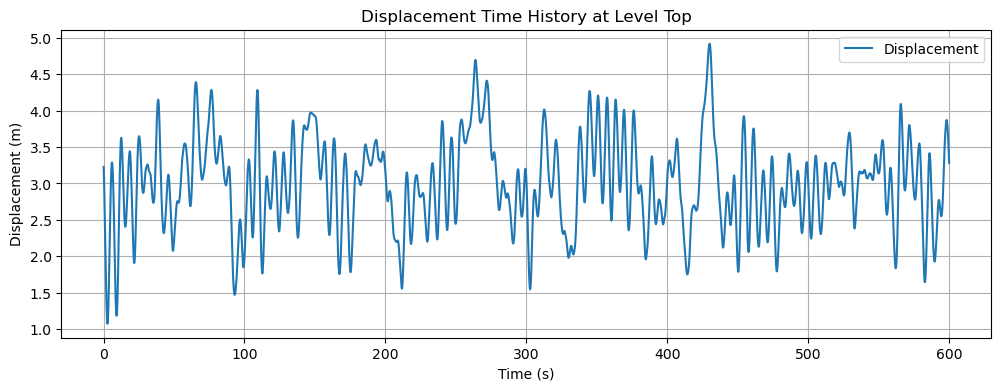

In [4]:
# 2. 频域方法计算
result = windload.calculate_static_wind_load_Frequency()

y = structural_analysis.calculate_displacement_Frequency(result)
print(f"y shape: {y.shape}")
print(f"y: {y}")

# 计算位移时程极值
y_top = y[:,-1]  # 提取顶点位移时程
y_top_peak = np.mean(y_top) + g * np.std(y_top)
print(f"\n结构顶部位移峰值为: {y_top_peak:.2f} m")

plt.figure(figsize=(12, 4))
plt.plot(t, y_top, label='Displacement')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.title('Displacement Time History at Level Top')
plt.grid(True)
plt.legend()
plt.show()